In [1]:
import netCDF4 as nc
from matplotlib import pyplot as plt
import numpy as np
import glob
import pickle
from salishsea_tools import evaltools as et
import datetime as dt
import os
import re
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=mesh.variables['tmask'][0,:,:,:]
    e1t=np.expand_dims(mesh.variables['e1t'][:,:,:],1)
    e2t=np.expand_dims(mesh.variables['e2t'][:,:,:],1)
SOGtmaskPath='/ocean/eolson/MEOPAR/northernNO3PaperCalcs/save/SOGtmask.pkl'
(tmaskSOG,_,_,_,_)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
idir='/data/sallen/results/MEOPAR/fluxes/01jan13'

In [4]:
fP=nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_dian_T.nc')[0])

In [5]:
fP.variables.keys()

dict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'deptht', 'deptht_bounds', 'PPDIATNO3V', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'PPPHYNO3V', 'PPMRUBNO3V', 'RIVNO3', 'BIOTRNO3', 'PHYSTRNO3', 'AFILTNO3', 'NITR', 'NO3_E3T', 'e3t'])

0.0 85.05775


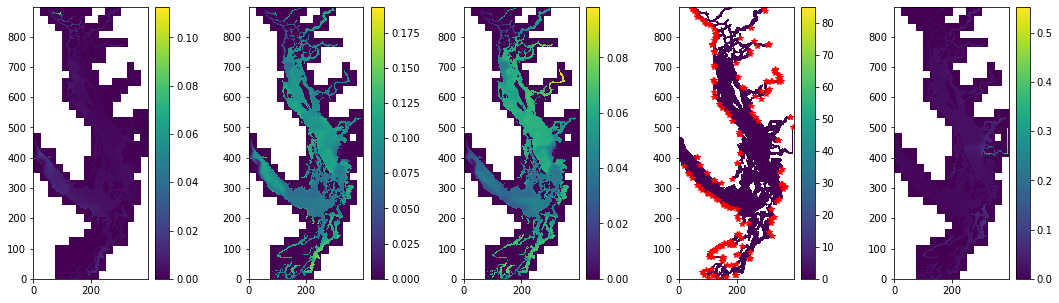

In [6]:
fig,ax=plt.subplots(1,5,figsize=(18,5))
fig.subplots_adjust(wspace=.5)
m0=ax[0].pcolormesh(fP.variables['PPDIATNO3V'][0,2,:,:])
plt.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(fP.variables['PPPHYNO3V'][0,2,:,:])
plt.colorbar(m1,ax=ax[1])
m2=ax[2].pcolormesh(fP.variables['PPMRUBNO3V'][0,2,:,:])
plt.colorbar(m2,ax=ax[2])
riv=np.ma.masked_where(tmask==0,fP.variables['RIVNO3'][0,:,:,:])
m3=ax[3].pcolormesh(riv[0,:,:])
plt.colorbar(m3,ax=ax[3])
m4=ax[4].pcolormesh(fP.variables['NITR'][0,2,:,:])
plt.colorbar(m4,ax=ax[4])
test=np.argwhere(riv[0,:,:]>0)
print(np.min(riv),np.max(riv))
ax[3].plot(test[:,1],test[:,0],'r*')

In [7]:
ii=(test[:,1]>300)&(test[:,0]>490)&(test[:,0]<510)
test[ii,:]

array([[500, 394]])

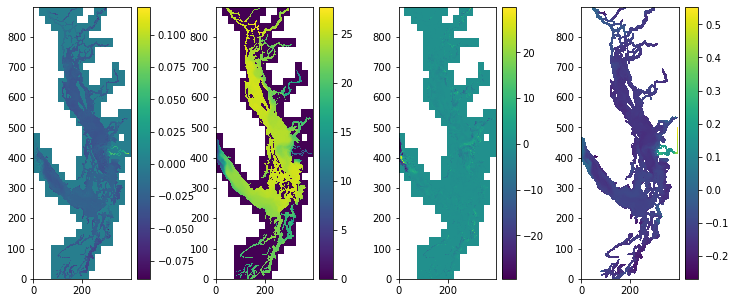

In [8]:
fig,ax=plt.subplots(1,4,figsize=(12,5))
fig.subplots_adjust(wspace=.5)
m0=ax[0].pcolormesh(fP.variables['AFILTNO3'][0,2,:,:])
plt.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(fP.variables['NO3_E3T'][0,2,:,:])
plt.colorbar(m1,ax=ax[1])
m2=ax[2].pcolormesh(fP.variables['PHYSTRNO3'][0,2,:,:])
plt.colorbar(m2,ax=ax[2])
bio=np.ma.masked_where(tmask==0,fP.variables['BIOTRNO3'][0,:,:,:])
m3=ax[3].pcolormesh(bio[2,:,:])
plt.colorbar(m3,ax=ax[3])

In [9]:
np.shape(tmaskSOG)

(1, 40, 898, 398)

In [10]:
no3sum=np.sum(np.sum(np.sum(tmaskSOG*e1t*e2t*fP.variables['NO3_E3T'][:,:,:,:],3),2),1)
physSum=np.sum(np.sum(np.sum(tmaskSOG*fP.variables['PHYSTRNO3'][:,:,:,:],3),2),1)
bioSum=np.sum(np.sum(np.sum(tmaskSOG*fP.variables['BIOTRNO3'][:,:,:,:],3),2),1)
rivSum=np.sum(np.sum(np.sum(tmaskSOG*fP.variables['RIVNO3'][:,:,:,:],3),2),1)*40
nitrSum=np.sum(np.sum(np.sum(tmaskSOG*fP.variables['NITR'][:,:,:,:],3),2),1)
PPSum=np.sum(np.sum(np.sum(tmaskSOG*(fP.variables['PPDIATNO3V'][:,:,:,:]+\
                                             fP.variables['PPPHYNO3V'][:,:,:,:]+\
                                             fP.variables['PPMRUBNO3V'][:,:,:,:]),3),2),1)
afiltSum=np.sum(np.sum(np.sum(tmaskSOG*fP.variables['AFILTNO3'][:,:,:,:],3),2),1)

In [11]:
no3diff=(no3sum[1:]-no3sum[:-1])/(24*3600)

In [12]:
24*3600/2160

40.0

In [13]:
rivSum*40/1000 #mmol/2 

masked_array(data=[893.7860107421875, 893.5157470703125, 887.85888671875,
                   885.10595703125, 890.0692749023438],
             mask=[False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [14]:
afiltSum

masked_array(data=[-227.48712158203125, -4587.17041015625, -7927.80859375,
                   -1473.94287109375, 8590.578125],
             mask=[False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

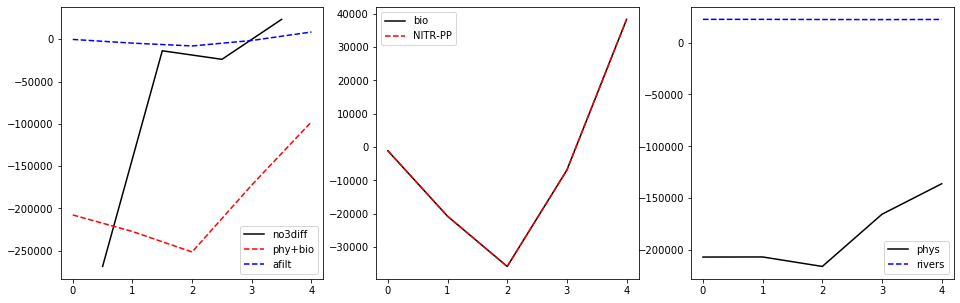

In [15]:
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(0.5,4,1),no3diff,'k-',label='no3diff')
ax[0].plot(range(0,5),physSum+bioSum,'r--',label='phy+bio')
ax[0].plot(range(0,5),afiltSum,'b--',label='afilt')
ax[0].legend()
ax[1].plot(range(0,5),bioSum,'k-',label='bio')
ax[1].plot(range(0,5),nitrSum-PPSum,'r--',label='NITR-PP')
ax[1].legend()
ax[2].plot(range(0,5),physSum,'k-',label='phys')
ax[2].plot(range(0,5),rivSum,'b--',label='rivers')
ax[2].legend()

In [16]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_Malaspina_U.nc')[0]) as f:
    malUA=np.sum(np.sum(f.variables['NO3_UT'][:,:,:,0],2),1)
    malUD=np.sum(np.sum(f.variables['ULDFNO3T'][:,:,:,0],2),1)

In [17]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_Haro_V.nc')[0]) as f:
    harVA=np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1)
    harVD=np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1)

In [18]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_SJC_V.nc')[0]) as f:
    sjcVA=np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1)
    sjcVD=np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1)

In [19]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_Rosario_V.nc')[0]) as f:
    rosVA=np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1)
    rosVD=np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1)

In [20]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_Sutil_V.nc')[0]) as f:
    sutVA=np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1)
    sutVD=np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1)

In [21]:
with nc.Dataset(glob.glob(idir+'/SalishSea_1d_*_Discovery_V.nc')[0]) as f:
    disVA=np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1)
    disVD=np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1)

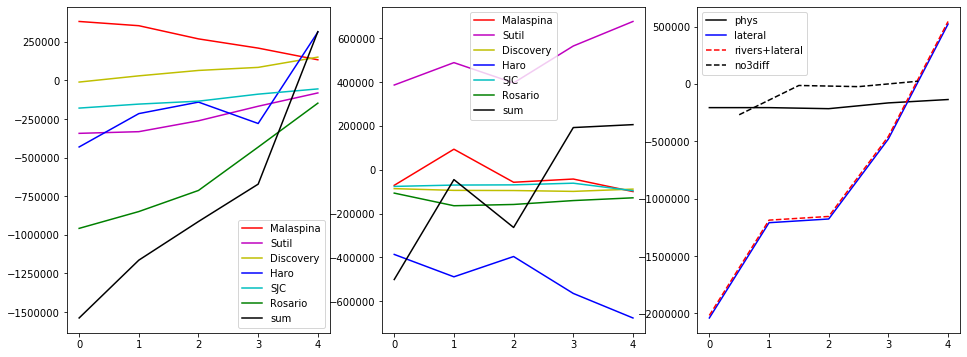

In [22]:
fig,ax=plt.subplots(1,3,figsize=(16,6))
ax[0].plot(range(0,5),-1*malUA,'r-',label='Malaspina')
ax[0].plot(range(0,5),-1*sutVA,'m-',label='Sutil')
ax[0].plot(range(0,5),-1*disVA,'y-',label='Discovery')
ax[0].plot(range(0,5),harVA,'b-',label='Haro')
ax[0].plot(range(0,5),sjcVA,'c-',label='SJC')
ax[0].plot(range(0,5),rosVA,'g-',label='Rosario')
ax[0].plot(range(0,5),harVA+sjcVA+rosVA-disVA-sutVA-malUA,'k-',label='sum')
ax[0].legend()
ax[1].plot(range(0,5),-1*malUD,'r-',label='Malaspina')
ax[1].plot(range(0,5),-1*sutVD,'m-',label='Sutil')
ax[1].plot(range(0,5),-1*disVD,'y-',label='Discovery')
ax[1].plot(range(0,5),sutVD,'b-',label='Haro')
ax[1].plot(range(0,5),sjcVD,'c-',label='SJC')
ax[1].plot(range(0,5),rosVD,'g-',label='Rosario')
ax[1].plot(range(0,5),harVD+sjcVD+rosVD-disVD-sutVD-malUD,'k-',label='sum')
ax[1].legend()
ax[2].plot(range(0,5),physSum,'k-',label='phys')
ax[2].plot(range(0,5),harVA+sjcVA+rosVA-disVA-sutVA-malUA+harVD+sjcVD+rosVD-disVD-sutVD-malUD,'b-',label='lateral')
ax[2].plot(range(0,5),harVA+sjcVA+rosVA-disVA-sutVA-malUA+harVD+sjcVD+rosVD-disVD-sutVD-malUD+rivSum,'r--',label='rivers+lateral')
ax[2].plot(np.arange(0.5,4,1),no3diff,'k--',label='no3diff')
ax[2].legend()